
🌊 Procesando: 202308mazatlan_T1.shp
🔍 Verificando topología...
✅ Geometría válida
🔗 Nodo inicial: (354204.3051122679, 2564805.6855206024)
🔗 Nodo final: (347512.3828924208, 2577949.597933415)
📏 Distancia extremos: 14749.38 m
✅ Sin autointersecciones


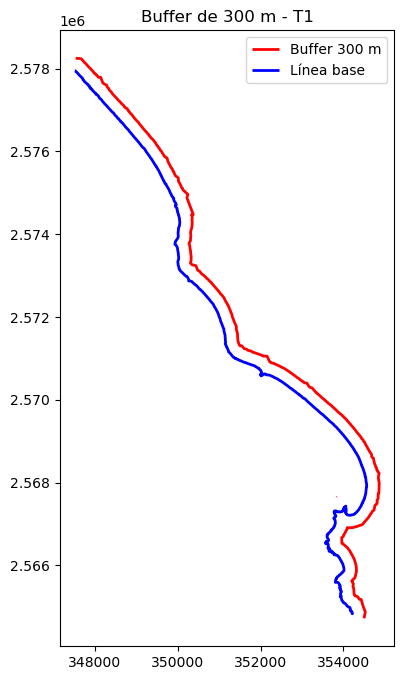

✅ Guardado:
 - C:\1_ENSOCE\C4_Estaciones\baseline_mz_T1.geojson
 - C:\1_ENSOCE\C4_Estaciones\baseline_mz_dsas_T1.geojson

🌊 Procesando: 202308mazatlan_T2.shp
🔍 Verificando topología...
✅ Geometría válida
🔗 Nodo inicial: (347800.3119118026, 2578323.687752865)
🔗 Nodo final: (334218.0137179616, 2597376.382729358)
📏 Distancia extremos: 23398.38 m
✅ Sin autointersecciones


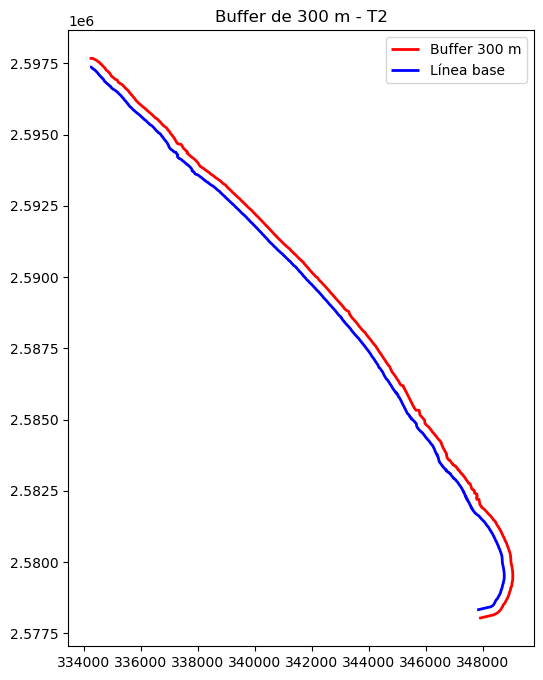

✅ Guardado:
 - C:\1_ENSOCE\C4_Estaciones\baseline_mz_T2.geojson
 - C:\1_ENSOCE\C4_Estaciones\baseline_mz_dsas_T2.geojson

🌊 Procesando: 202308mazatlan_T3.shp
🔍 Verificando topología...
✅ Geometría válida
🔗 Nodo inicial: (333951.14839692495, 2598996.5533395107)
🔗 Nodo final: (320166.66208569845, 2612470.203307082)
📏 Distancia extremos: 19275.67 m
✅ Sin autointersecciones


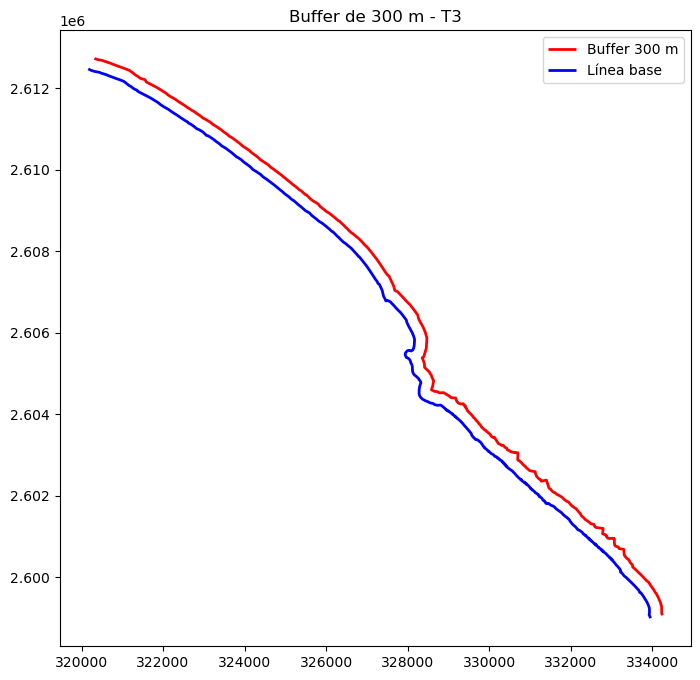

✅ Guardado:
 - C:\1_ENSOCE\C4_Estaciones\baseline_mz_T3.geojson
 - C:\1_ENSOCE\C4_Estaciones\baseline_mz_dsas_T3.geojson


In [1]:
import os
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import linemerge, unary_union, snap
from shapely.validation import explain_validity
import matplotlib.pyplot as plt

# ========= CONFIGURACIÓN =========
input_folder = r"C:\1_ENSOCE\C3_Output\shapes"
output_folder = r"C:\1_ENSOCE\C4_Estaciones"
archivos = ["202308mazatlan_T1", "202308mazatlan_T2", "202308mazatlan_T3"]
tolerance = 5  # metros para snap
offset_dist = 300  # metros para desplazamiento

for nombre in archivos:
    print(f"\n🌊 Procesando: {nombre}.shp")
    
    input_path = os.path.join(input_folder, f"{nombre}.shp")
    output_path = os.path.join(output_folder, f"baseline_mz_{nombre[-2:]}.geojson")
    output_path_dsas = os.path.join(output_folder, f"baseline_mz_dsas_{nombre[-2:]}.geojson")

    # ========= 1. Cargar y reproyectar =========
    gdf = gpd.read_file(input_path).to_crs(epsg=32613)

    # ========= 2. Snapping y unión =========
    snapped = [snap(geom, unary_union(gdf.geometry), tolerance) for geom in gdf.geometry]
    union_geom = unary_union(snapped)

    if isinstance(union_geom, LineString):
        merged = union_geom
    else:
        merged = linemerge(union_geom)

    # ========= 3. Asegurar LineString continua =========
    if merged.geom_type == "MultiLineString":
        print("⚠️ MultiLineString detectada. Uniendo...")
        coords = []
        for line in merged.geoms:
            coords.extend(line.coords)
        baseline = LineString(coords)
    else:
        baseline = merged

    # ========= 4. Verificación topológica =========
    print("🔍 Verificando topología...")
    if not baseline.is_valid:
        reason = explain_validity(baseline)
        print(f"❌ Geometría NO válida: {reason}")
        baseline_fixed = baseline.buffer(0)
        if baseline_fixed.is_valid:
            print("✅ Reparación con buffer(0) exitosa.")
            baseline = baseline_fixed
        else:
            print("❌ Reparación fallida. Geometría aún inválida.")
    else:
        print("✅ Geometría válida")

    coords = list(baseline.coords)
    start, end = coords[0], coords[-1]
    print(f"🔗 Nodo inicial: {start}")
    print(f"🔗 Nodo final: {end}")
    print(f"📏 Distancia extremos: {LineString([start, end]).length:.2f} m")

    reason = explain_validity(baseline)
    if "Self-intersection" in reason:
        print("❌ Autointersección:", reason)
    else:
        print("✅ Sin autointersecciones")

    # ========= 5. Crear GeoDataFrame =========
    baseline_gdf = gpd.GeoDataFrame({
        'Id': [1],
        'Attribute': [f'baseline_{nombre[-2:]}']
    }, geometry=[baseline], crs="EPSG:32613")

    # ========= 6. Crear desplazamiento hacia tierra firme =========
    try:
        offset_geom = baseline.parallel_offset(distance=offset_dist, side='right', resolution=64, join_style=2)
        buffer_gdf = gpd.GeoDataFrame({
            'Id': [1],
            'Attribute': [f'baseline_offset_{nombre[-2:]}']
        }, geometry=[offset_geom], crs="EPSG:32613")

        # ========= 7. Mostrar figura =========
        fig, ax = plt.subplots(figsize=(10, 8))
        buffer_gdf.plot(ax=ax, color='red', edgecolor='black', linewidth=2, label='Buffer 300 m')
        baseline_gdf.plot(ax=ax, color='blue', linewidth=2, label='Línea base')
        plt.title(f"Buffer de 300 m - {nombre[-2:]}")
        plt.legend()
        plt.show()

        # ========= 8. Guardar =========
        buffer_gdf.to_file(output_path_dsas, driver="GeoJSON")
        baseline_gdf.to_file(output_path, driver="GeoJSON")
        print(f"✅ Guardado:\n - {output_path}\n - {output_path_dsas}")

    except Exception as e:
        print(f"❌ Error al crear el desplazamiento: {e}")



🌊 Procesando: 202308mazatlan_T1.shp
🔍 Verificando topología...
✅ Geometría válida
🔗 Nodo inicial: (354204.3051122679, 2564805.6855206024)
🔗 Nodo final: (347512.3828924208, 2577949.597933415)
📏 Distancia extremos: 14749.38 m
✅ Sin autointersecciones


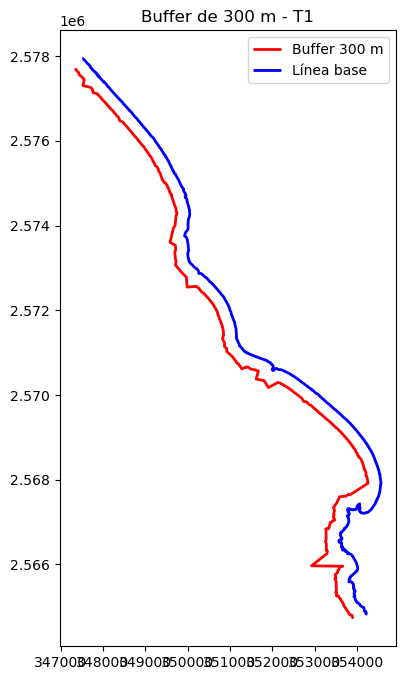

✅ Guardado:
 - C:\1_ENSOCE\C4_Estaciones\baseline_sea_mz_T1.geojson
 - C:\1_ENSOCE\C4_Estaciones\baseline_sea_mz_dsas_T1.geojson

🌊 Procesando: 202308mazatlan_T2.shp
🔍 Verificando topología...
✅ Geometría válida
🔗 Nodo inicial: (347800.3119118026, 2578323.687752865)
🔗 Nodo final: (334218.0137179616, 2597376.382729358)
📏 Distancia extremos: 23398.38 m
✅ Sin autointersecciones


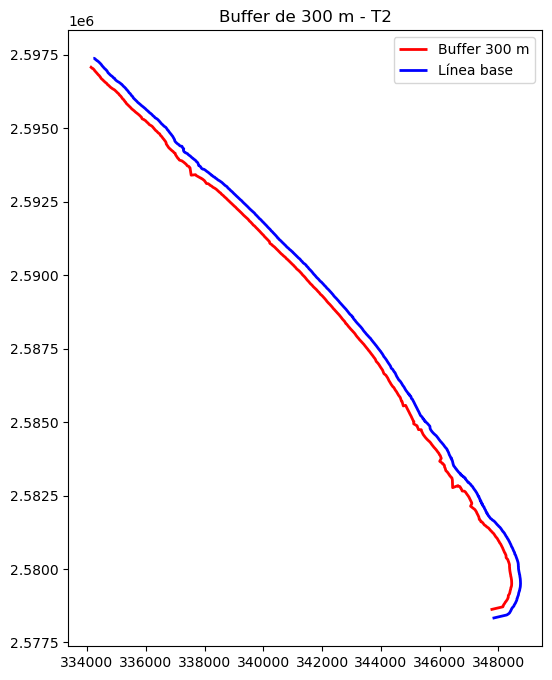

✅ Guardado:
 - C:\1_ENSOCE\C4_Estaciones\baseline_sea_mz_T2.geojson
 - C:\1_ENSOCE\C4_Estaciones\baseline_sea_mz_dsas_T2.geojson

🌊 Procesando: 202308mazatlan_T3.shp
🔍 Verificando topología...
✅ Geometría válida
🔗 Nodo inicial: (333951.14839692495, 2598996.5533395107)
🔗 Nodo final: (320166.66208569845, 2612470.203307082)
📏 Distancia extremos: 19275.67 m
✅ Sin autointersecciones


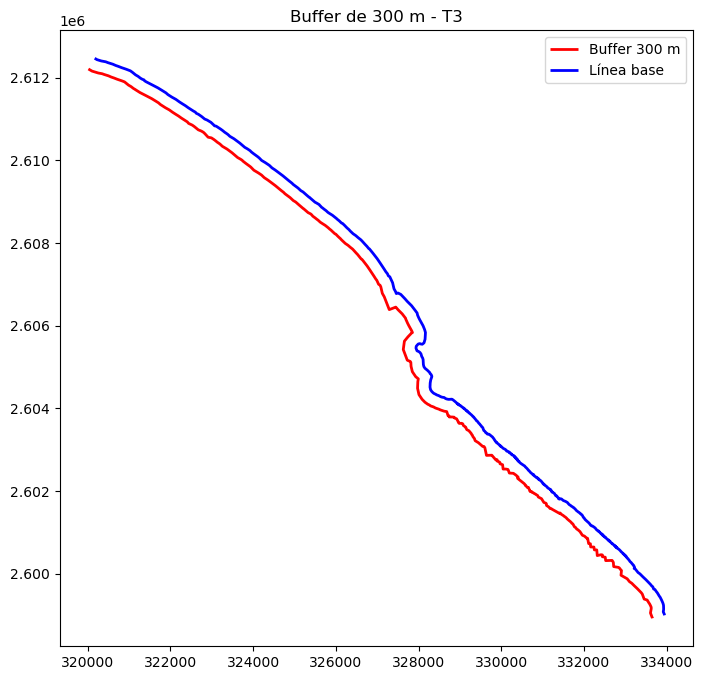

✅ Guardado:
 - C:\1_ENSOCE\C4_Estaciones\baseline_sea_mz_T3.geojson
 - C:\1_ENSOCE\C4_Estaciones\baseline_sea_mz_dsas_T3.geojson


In [2]:
import os
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import linemerge, unary_union, snap
from shapely.validation import explain_validity
import matplotlib.pyplot as plt

# ========= CONFIGURACIÓN =========
input_folder = r"C:\1_ENSOCE\C3_Output\shapes"
output_folder = r"C:\1_ENSOCE\C4_Estaciones"
archivos = ["202308mazatlan_T1", "202308mazatlan_T2", "202308mazatlan_T3"]
tolerance = 5  # metros para snap
offset_dist = 300  # metros para desplazamiento

for nombre in archivos:
    print(f"\n🌊 Procesando: {nombre}.shp")
    
    input_path = os.path.join(input_folder, f"{nombre}.shp")
    output_path = os.path.join(output_folder, f"baseline_sea_mz_{nombre[-2:]}.geojson")
    output_path_dsas = os.path.join(output_folder, f"baseline_sea_mz_dsas_{nombre[-2:]}.geojson")

    # ========= 1. Cargar y reproyectar =========
    gdf = gpd.read_file(input_path).to_crs(epsg=32613)

    # ========= 2. Snapping y unión =========
    snapped = [snap(geom, unary_union(gdf.geometry), tolerance) for geom in gdf.geometry]
    union_geom = unary_union(snapped)

    if isinstance(union_geom, LineString):
        merged = union_geom
    else:
        merged = linemerge(union_geom)

    # ========= 3. Asegurar LineString continua =========
    if merged.geom_type == "MultiLineString":
        print("⚠️ MultiLineString detectada. Uniendo...")
        coords = []
        for line in merged.geoms:
            coords.extend(line.coords)
        baseline = LineString(coords)
    else:
        baseline = merged

    # ========= 4. Verificación topológica =========
    print("🔍 Verificando topología...")
    if not baseline.is_valid:
        reason = explain_validity(baseline)
        print(f"❌ Geometría NO válida: {reason}")
        baseline_fixed = baseline.buffer(0)
        if baseline_fixed.is_valid:
            print("✅ Reparación con buffer(0) exitosa.")
            baseline = baseline_fixed
        else:
            print("❌ Reparación fallida. Geometría aún inválida.")
    else:
        print("✅ Geometría válida")

    coords = list(baseline.coords)
    start, end = coords[0], coords[-1]
    print(f"🔗 Nodo inicial: {start}")
    print(f"🔗 Nodo final: {end}")
    print(f"📏 Distancia extremos: {LineString([start, end]).length:.2f} m")

    reason = explain_validity(baseline)
    if "Self-intersection" in reason:
        print("❌ Autointersección:", reason)
    else:
        print("✅ Sin autointersecciones")

    # ========= 5. Crear GeoDataFrame =========
    baseline_gdf = gpd.GeoDataFrame({
        'Id': [1],
        'Attribute': [f'baseline_{nombre[-2:]}']
    }, geometry=[baseline], crs="EPSG:32613")

    # ========= 6. Crear desplazamiento hacia tierra firme =========
    try:
        offset_geom = baseline.parallel_offset(distance=offset_dist, side='left', resolution=64, join_style=2)
        buffer_gdf = gpd.GeoDataFrame({
            'Id': [1],
            'Attribute': [f'baseline_offset_{nombre[-2:]}']
        }, geometry=[offset_geom], crs="EPSG:32613")

        # ========= 7. Mostrar figura =========
        fig, ax = plt.subplots(figsize=(10, 8))
        buffer_gdf.plot(ax=ax, color='red', edgecolor='black', linewidth=2, label='Buffer 300 m')
        baseline_gdf.plot(ax=ax, color='blue', linewidth=2, label='Línea base')
        plt.title(f"Buffer de 300 m - {nombre[-2:]}")
        plt.legend()
        plt.show()

        # ========= 8. Guardar =========
        buffer_gdf.to_file(output_path_dsas, driver="GeoJSON")
        baseline_gdf.to_file(output_path, driver="GeoJSON")
        print(f"✅ Guardado:\n - {output_path}\n - {output_path_dsas}")

    except Exception as e:
        print(f"❌ Error al crear el desplazamiento: {e}")


In [3]:
import geopandas as gpd
import os
import rasterio

# Leer tamaño de píxel desde un TIFF de referencia
tiff_path = r"C:\1_ENSOCE\C4_Estaciones\2022\primavera\clips\clip_VH_flood_sauvola_sauvola.tif"  # Cambia a tu ruta de TIFF
with rasterio.open(tiff_path) as src:
    pixel_size = src.res[0]  # grados

print(f"Tamaño de píxel ≈ {pixel_size*111000:.2f} metros")
simplify_tolerance = pixel_size * 0.7  # ~5 metros
buffer_amount = pixel_size * 0.1       # ~2 metros

def suavizar_shapefiles_en_carpeta(folder_path, tolerance, buffer_val):
    for file in os.listdir(folder_path):
        if file.endswith(".shp") and "filtered" in file and not file.endswith("_suavizado.shp"):
            shp_path = os.path.join(folder_path, file)
            gdf = gpd.read_file(shp_path)
            print(f"🌀 Suavizando (simplify + buffer): {file}")

            # Paso 1: simplify para mantener bordes limpios
            gdf['geometry'] = gdf['geometry'].simplify(tolerance=tolerance, preserve_topology=True)

            # Paso 2: buffer suave para redondear dientes
            gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)

            # Crear nuevo nombre con sufijo "_suavizado"
            base_name = file[:-4]
            new_filename = base_name + "_suavizado.shp"
            new_path = os.path.join(folder_path, new_filename)

            gdf.to_file(new_path)
            print(f"✅ Guardado: {new_path}")

# Ejecutar
#suavizar_shapefiles_en_carpeta(tiff_folder, tolerance=simplify_tolerance, buffer_val=buffer_amount)


Tamaño de píxel ≈ 9.97 metros


In [4]:
"""
import rasterio
from collections import Counter

res_counter = Counter()
for path in todos_los_tifs:
    with rasterio.open(path) as src:
        res_counter[src.res] += 1

for res, n in res_counter.items():
    print(f"Resolución {res} → {n} archivos")

#NameError: name 'todos_los_tifs' is not defined
"""

'\nimport rasterio\nfrom collections import Counter\n\nres_counter = Counter()\nfor path in todos_los_tifs:\n    with rasterio.open(path) as src:\n        res_counter[src.res] += 1\n\nfor res, n in res_counter.items():\n    print(f"Resolución {res} → {n} archivos")\n\n#NameError: name \'todos_los_tifs\' is not defined\n'

In [5]:
import os
import glob
from pathlib import Path
from typing import List

import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject




# ------------ CONFIGURACIÓN -----------------
src_base      = r"C:\1_ENSOCE\C3_Output"                # donde están los .tif originales
dst_base      = r"C:\1_ENSOCE\C3_Output\32613"          # salida re‑proyectada
anio_list     = [2022, 2023, 2024]
meses_output  = [
    '1_enero', '2_febrero', '3_marzo', '4_abril', '5_mayo', '6_junio',
    '7_julio', '8_agosto', '9_septiembre', '10_octubre', '11_noviembre', '12_diciembre'
]
dst_crs       = "EPSG:32613"   # UTM Zone 13 N  (metros)
dst_res       = 10            # tamaño de píxel (10 m × 10 m)
resampling_alg = Resampling.bilinear   # nearest, bilinear, cubic …

# ------------ FUNCIÓN DE REMUESTREO -----------
def resample_to_32613_10m(src_path: str, dst_path: str):
    """Re‑proyecta y remuestrea un raster a 10 m en EPSG:32613."""
    if os.path.exists(dst_path):
        return  # ya procesado

    with rasterio.open(src_path) as src:
        # Transformación a la malla de 10 m
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=dst_res
        )

        meta = src.meta.copy()
        meta.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
        })

        os.makedirs(Path(dst_path).parent, exist_ok=True)

        with rasterio.open(dst_path, "w", **meta) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling_alg,
                )
    print(f"✅ Remuestreado: {src_path} → {dst_path}")

# ------------ BUCLE PRINCIPAL ----------------


todos_tifs_32613: List[str] = []

for anio in anio_list:
    for mes in meses_output:
        src_folder = rf"{src_base}\{anio}\{mes}"
        dst_folder = rf"{dst_base}\{anio}\{mes}"
        for tif in glob.glob(os.path.join(src_folder, "*.tif")):
            dst_tif = rf"{dst_folder}\{Path(tif).name}"
            resample_to_32613_10m(tif, dst_tif)
            todos_tifs_32613.append(dst_tif)

print(f"\n🎯 Total convertidos/listos en EPSG:32613 = {len(todos_tifs_32613)} archivos")



🎯 Total convertidos/listos en EPSG:32613 = 36 archivos


In [6]:
import json, os
from typing import List, Dict, Tuple
import rasterio
from rasterio.errors import RasterioIOError
from shapely.geometry import box
from shapely.ops import unary_union
import geopandas as gpd

def recortar_rasters_a_interseccion_comun(
    raster_paths: List[str],
    carpeta_output: str,
    guardar_geojson: bool = True
) -> Dict[str, Tuple]:
    if not raster_paths:
        raise ValueError("La lista de rasters está vacía.")

    footprints, metas = [], {}
    first_crs = first_res = None

    for path in raster_paths:
        with rasterio.open(path) as src:
            bounds, crs, res = src.bounds, src.crs, src.res
            metas[path] = {"bounds": bounds,
                           "width_px": src.width,
                           "height_px": src.height}
            if first_crs is None:
                first_crs, first_res = crs, res
            else:
                if crs != first_crs or res != first_res:
                    raise ValueError(f"CRS o resolución distinta en {path}")
            footprints.append(box(*bounds))

    inter = footprints[0]
    for fp in footprints[1:]:
        inter = inter.intersection(fp)
    if inter.is_empty:
        raise RuntimeError("No hay área común entre los rasters.")

    left, bottom, right, top = inter.bounds
    px = int(round((right - left) / first_res[0]))
    py = int(round((top   - bottom) / abs(first_res[1])))

    resultado = {
        "bounds": (left, bottom, right, top),
        "crs": first_crs.to_wkt(),
        "width_px": px,
        "height_px": py,
        "rasters": metas,
    }

    os.makedirs(carpeta_output, exist_ok=True)
    with open(os.path.join(carpeta_output, "interseccion_metadata.json"), "w") as f:
        json.dump(resultado, f, indent=2)
    if guardar_geojson:
        gpd.GeoDataFrame({"id":[1]}, geometry=[inter], crs=first_crs
                         ).to_file(os.path.join(carpeta_output,
                                   "interseccion_comun.geojson"),
                                   driver="GeoJSON")
    return resultado

# ------------ INTERSECCIÓN GLOBAL -------------
from pathlib import Path

carpeta_interseccion_global = rf"{dst_base}\interseccion_global"

print(f"\n🔍 Analizando intersección global de {len(todos_tifs_32613)} TIF…")
info_global = recortar_rasters_a_interseccion_comun(
    todos_tifs_32613,
    carpeta_interseccion_global,
    guardar_geojson=True
)

print("\n✅ Intersección lista")
print("   Bounds:", info_global["bounds"])
print("   Dimensiones (px):", info_global["width_px"], "x", info_global["height_px"])
print("   Archivo GeoJSON:", rf"{carpeta_interseccion_global}\interseccion_comun.geojson")



🔍 Analizando intersección global de 36 TIF…

✅ Intersección lista
   Bounds: (313115.56212116673, 2563163.773140269, 363699.1683862804, 2613287.0491627012)
   Dimensiones (px): 5058 x 5012
   Archivo GeoJSON: C:\1_ENSOCE\C3_Output\32613\interseccion_global\interseccion_comun.geojson


In [7]:
import os
import glob
import json
from pathlib import Path

import rasterio
from rasterio.windows import from_bounds

# ---------- RUTAS ----------
base_in   = r"C:\1_ENSOCE\C3_Output\32613"        # donde están los tif re‑muestreados
base_clip = r"C:\1_ENSOCE\C3_Output\32613\clip"   # salida
meta_json = rf"{base_in}\interseccion_global\interseccion_metadata.json"

# ---------- LEER METADATA ----------
with open(meta_json, "r", encoding="utf-8") as f:
    meta = json.load(f)

left, bottom, right, top = meta["bounds"]
clip_bounds = (left, bottom, right, top)
clip_width  = meta["width_px"]
clip_height = meta["height_px"]

def clip_raster(src_path: str, dst_path: str):
    """Recorta src_path a clip_bounds y guarda en dst_path."""
    if os.path.exists(dst_path):
        return  # ya procesado

    with rasterio.open(src_path) as src:
        # Ventana de recorte en coordenadas de píxel
        window = from_bounds(*clip_bounds, transform=src.transform)
        # Ajustar a dimensiones exactas (seguro porque todos los tif están alineados)
        window = window.round_offsets().round_lengths()

        # Sub‐transform del recorte
        transform = src.window_transform(window)

        # Meta para el nuevo archivo
        kwargs = src.meta.copy()
        kwargs.update({
            "height": clip_height,
            "width":  clip_width,
            "transform": transform,
            "compress": "lzw",
        })

        # Crear carpeta de destino
        Path(dst_path).parent.mkdir(parents=True, exist_ok=True)

        with rasterio.open(dst_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                dst.write(src.read(i, window=window), i)

    print(f"✂️  Clipped: {src_path} → {dst_path}")

# ---------- BUCLE PRINCIPAL ----------
for tif in glob.glob(rf"{base_in}\*\*\*.tif"):     # patrón año\mes\*.tif
    rel = Path(tif).relative_to(base_in)           # p.ej. 2022/1_enero/file.tif
    dst_tif = Path(base_clip) / rel
    clip_raster(tif, str(dst_tif))

print("\n✅ Todos los rásteres recortados a 5058 × 5012 píxeles")
print(f"   Carpeta de salida: {base_clip}")



✅ Todos los rásteres recortados a 5058 × 5012 píxeles
   Carpeta de salida: C:\1_ENSOCE\C3_Output\32613\clip


In [8]:
import os
import glob
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import Affine
from pathlib import Path

# -------------------------------------------------------
# 1. Configuración
# -------------------------------------------------------
clip_base = r"C:\1_ENSOCE\C3_Output\32613\clip"  # rásteres recortados
out_base  = r"C:\1_ENSOCE\C4_Estaciones"         # carpeta final de promedios

anios = [2022, 2023, 2024]
meses_output = [
    '1_enero', '2_febrero', '3_marzo', '4_abril', '5_mayo', '6_junio',
    '7_julio', '8_agosto', '9_septiembre', '10_octubre', '11_noviembre', '12_diciembre'
]

umbral = 0.5  # <——  ajuste aquí si necesitas otro valor

# Épocas (mes, delta) = (mes, desplazamiento de año: −1 = diciembre anterior)
epocas = {
    "invierno":  [(12, -1), (1, 0), (2, 0), (3, 0)],
    "primavera": [(3, 0),  (4, 0), (5, 0), (6, 0)],
    "verano":    [(6, 0),  (7, 0), (8, 0), (9, 0)],
    "otoño":     [(9, 0),  (10, 0), (11, 0), (12, 0)],
}
epocas_inicio = {          # para 2022, sin diciembre previo
    "invierno":  [(1, 0), (2, 0), (3, 0)],
    "primavera": [(3, 0), (4, 0), (5, 0), (6, 0)],
    "verano":    [(6, 0), (7, 0), (8, 0), (9, 0)],
    "otoño":     [(9, 0), (10, 0), (11, 0), (12, 0)],
}

# -------------------------------------------------------
# 2. Función de promedio (una banda)
# -------------------------------------------------------

def promedio_a_binario(raster_paths, out_bin, thr=0.5):
    """
    Promedia rásteres alineados y guarda solo el resultado binario (0/1),
    convirtiendo cualquier valor nodata (‑9999, etc.) a 0.
    """
    if not raster_paths:
        print(f"⚠️  Sin TIF → {out_bin}")
        return

    # ---------- Preparar acumuladores ----------
    with rasterio.open(raster_paths[0]) as ref:
        meta        = ref.meta.copy()
        orig_nodata = ref.nodata  # puede ser -9999 o None
        h, w        = ref.height, ref.width
        suma   = np.zeros((h, w), dtype="float32")
        cuenta = np.zeros((h, w), dtype="int16")

    # ---------- Sumar todos los raster ----------
    for tif in raster_paths:
        with rasterio.open(tif) as src:
            arr   = src.read(1).astype("float32")
            mask  = (arr == orig_nodata) if orig_nodata is not None else np.zeros_like(arr, bool)
            suma  += np.where(mask, 0.0, arr)
            cuenta += (~mask)

    # ---------- Promedio en RAM ----------
    promedio = np.where(cuenta == 0, np.nan, suma / cuenta)

    # ---------- Binarizar ----------
    binario = np.where(
        np.isnan(promedio),            # donde no hubo datos válidos
        0,                              # ¡los ponemos en 0!
        np.where(promedio >= thr, 1, 0) # resto: 1 ó 0
    ).astype("uint8")

    # ---------- Guardar SOLO el binario ----------
    # Usamos nodata = 255 (valor libre) o None si prefieres sin nodata.
    meta.update(dtype="uint8", nodata=255, compress="lzw")
    Path(out_bin).parent.mkdir(parents=True, exist_ok=True)

    with rasterio.open(out_bin, "w", **meta) as dst:
        dst.write(binario, 1)

    print(f"✅ Binario guardado: {out_bin}")
# -------------------------------------------------------
# 3. Bucle principal
# -------------------------------------------------------
for anio in anios:
    usar_epocas = epocas_inicio if anio == 2022 else epocas

    for epoca, meses in usar_epocas.items():
        rutas = []
        for mes, delta in meses:
            anio_eff = anio + delta
            if anio_eff < 2022:
                continue  # evita dic‑2021
            mes_nom = meses_output[mes - 1]
            rutas.extend(glob.glob(os.path.join(
                clip_base, str(anio_eff), mes_nom, "*.tif"
            )))

        if not rutas:
            print(f"⚠️  {epoca} {anio}: sin datos")
            continue

        out_dir  = os.path.join(out_base, str(anio), epoca)
        out_bin  = os.path.join(out_dir, f"{epoca}_{anio}_binario.tif")
        promedio_a_binario(rutas, out_bin, thr=umbral)


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_25796\270844194.py:67: RuntimeWarning: invalid value encountered in divide
  promedio = np.where(cuenta == 0, np.nan, suma / cuenta)


✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2022\invierno\invierno_2022_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2022\primavera\primavera_2022_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2022\verano\verano_2022_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2022\otoño\otoño_2022_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2023\invierno\invierno_2023_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2023\primavera\primavera_2023_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2023\verano\verano_2023_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2023\otoño\otoño_2023_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2024\invierno\invierno_2024_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2024\primavera\primavera_2024_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2024\verano\verano_2024_binario.tif
✅ Binario guardado: C:\1_ENSOCE\C4_Estaciones\2024\otoño\otoño_2024_bina

In [9]:
import os
import re
import glob
import geopandas as gpd
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, LineString, MultiLineString
from shapely.ops import unary_union, linemerge
from pathlib import Path
import pandas as pd

# ---------------------------------------------------------------------------
# CONFIGURACIÓN
# ---------------------------------------------------------------------------
bin_base   = r"C:\1_ENSOCE\C4_Estaciones"            # donde están los *_binario.tif
out_geojson = r"C:\1_ENSOCE\C4_Estaciones\coastlines_32613.geojson"

# Mapeo de fecha representativa por época
fechas_epoca = {
    "invierno":  "02/15",  # MM/DD
    "primavera": "05/01",
    "verano":    "08/01",
    "otoño":     "11/01",
}

area_min = 1000  # m²  (polígonos menores se descartan)
uncertainty_val = 10  # constante

# ────────────────────────────────────────────────────────────────────────────
# FUNCIÓN AUXILIAR: raster binario  →  GeoDataFrame de líneas limpias
# ────────────────────────────────────────────────────────────────────────────
def binario_a_lineas(tif_path, date_str):
    """Convierte un binario 0/1 en líneas con limpieza y devuelve GeoDataFrame."""
    with rasterio.open(tif_path) as src:
        image = src.read(1)
        results = shapes(image, mask=(image == 1), transform=src.transform)

    # 1. shapes → lista de polígonos shapely
    polys = (shape(geom) for geom, value in results if value == 1)

    # 2. Filtrar por área
    polys = [p for p in polys if p.area >= area_min]
    if not polys:
        return gpd.GeoDataFrame(columns=["geometry", "id", "date", "uncertainty"], crs=src.crs)

    # 3. Unir polí­gonos contiguos (opcional, pero evita contornos duplicados)
    union = unary_union(polys)

    # 4. Obtener contorno(s) como MultiLineString
    if union.geom_type == "Polygon":
        lines = [LineString(union.exterior.coords)]
    else:  # MultiPolygon
        lines = [LineString(poly.exterior.coords) for poly in union.geoms]

   # 5. Fundir líneas que se tocan en un solo objeto
    merged = linemerge(lines)
    if merged.geom_type == "LineString":
        final_geom = merged
    elif merged.geom_type == "MultiLineString":
        final_geom = MultiLineString(list(merged.geoms))
    else:
        final_geom = merged  # fallback

    # 6. GeoDataFrame con UNA fila
    gdf = gpd.GeoDataFrame(
        {
            "geometry":   [final_geom],
            "date":       [date_str],
            "uncertainty":[uncertainty_val],
        },
        crs=src.crs
    )
    return gdf

# ────────────────────────────────────────────────────────────────────────────
# RECOPILAR TODOS LOS BINARIOS Y CONVERTIR
# ────────────────────────────────────────────────────────────────────────────
gdfs = []
bin_pattern = os.path.join(bin_base, "*", "*", "*_binario.tif")  # anio\epoca\file.tif

for tif_path in glob.glob(bin_pattern):
    # Extraer año y época del path:  ...\2023\invierno\invierno_2023_binario.tif
    m = re.search(rf"{re.escape(bin_base)}\\(\d{{4}})\\([a-zñ]+)\\", tif_path, re.IGNORECASE)
    if not m:
        print(f"⚠️  No se pudo inferir año/época en {tif_path}")
        continue
    anio, epoca = m.group(1), m.group(2).lower()

    if epoca not in fechas_epoca:
        print(f"⚠️  Época desconocida en ruta: {tif_path}")
        continue

    fecha = f"{fechas_epoca[epoca]}/{anio}"   # MM/DD/YYYY
    gdf = binario_a_lineas(tif_path, fecha)
    if not gdf.empty:
        gdfs.append(gdf)
        print(f"✅ {epoca} {anio}: {len(gdf)} líneas")

# ────────────────────────────────────────────────────────────────────────────
# CONCATENAR, ASIGNAR ID Y EXPORTAR
# ────────────────────────────────────────────────────────────────────────────
if gdfs:
    combined = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    combined["id"] = range(1, len(combined) + 1)  # id ascendente

    Path(out_geojson).parent.mkdir(parents=True, exist_ok=True)
    combined.to_file(out_geojson, driver="GeoJSON")
    print(f"\n💾 GeoJSON final guardado en: {out_geojson}")
    print(f"   Total líneas: {len(combined)}")
else:
    print("❌ No se generaron líneas (revisa los binarios y parámetros).")


✅ invierno 2022: 1 líneas
✅ otoño 2022: 1 líneas
✅ primavera 2022: 1 líneas
✅ verano 2022: 1 líneas
✅ invierno 2023: 1 líneas
✅ otoño 2023: 1 líneas
✅ primavera 2023: 1 líneas
✅ verano 2023: 1 líneas
✅ invierno 2024: 1 líneas
✅ otoño 2024: 1 líneas
✅ primavera 2024: 1 líneas
✅ verano 2024: 1 líneas

💾 GeoJSON final guardado en: C:\1_ENSOCE\C4_Estaciones\coastlines_32613.geojson
   Total líneas: 12


In [10]:
"""
import geopandas as gpd
from shapely.geometry import box
from rasterio.features import shapes
from rasterio.mask import mask
import rasterio
import json

# Directorio de salida para las costas recortadas
coastlines_dir = r"C:\1_ENSOCE\C4_Estaciones"

# Archivos base
baselines = {
    "T1": os.path.join(coastlines_dir, "baseline_mz_T1.geojson"),
    "T2": os.path.join(coastlines_dir, "baseline_mz_T2.geojson"),
    "T3": os.path.join(coastlines_dir, "baseline_mz_T3.geojson"),
}

# Lista de tifs reproyectados
for sufijo, baseline_path in baselines.items():
    print(f"\n✂️ Recortando con línea base {sufijo}")

    # Cargar línea base
    gdf_base = gpd.read_file(baseline_path).to_crs("EPSG:32613")
    geometry = [json.loads(gdf_base.to_json())["features"][0]["geometry"]]  # GeoJSON

    # Crear GeoDataFrame vacío para acumulación
    recorte_final = gpd.GeoDataFrame(columns=["geometry", "value"], crs="EPSG:32613")

    for tif_path in tifs:
        try:
            with rasterio.open(tif_path) as src:
                out_image, out_transform = mask(src, geometry, crop=True)
                out_image = out_image[0]  # primera banda

                # Extraer formas (polígonos) del raster recortado
                results = (
                    (geom, value)
                    for geom, value in shapes(out_image, mask=None, transform=out_transform)
                    if value != src.nodata
                )

                # Convertir a GeoJSON válido
                geoms = [
                    {
                        "type": "Feature",
                        "geometry": geom,
                        "properties": {"value": value}
                    }
                    for geom, value in results
                ]

                # Solo si hay geometrías válidas
                if geoms:
                    gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)
                    recorte_final = pd.concat([recorte_final, gdf], ignore_index=True)

        except Exception as e:
            print(f"⚠️ Error procesando {tif_path}: {e}")


    # Guardar resultado
    salida_path = os.path.join(coastlines_dir, f"coastlines_32613_{sufijo}.geojson")
    if not recorte_final.empty:
        recorte_final.to_file(salida_path, driver="GeoJSON")
        print(f"✅ Guardado: {salida_path}")
    else:
        print(f"⚠️ No se generaron geometrías para {sufijo}")
        """


'\nimport geopandas as gpd\nfrom shapely.geometry import box\nfrom rasterio.features import shapes\nfrom rasterio.mask import mask\nimport rasterio\nimport json\n\n# Directorio de salida para las costas recortadas\ncoastlines_dir = r"C:\x01_ENSOCE\\C4_Estaciones"\n\n# Archivos base\nbaselines = {\n    "T1": os.path.join(coastlines_dir, "baseline_mz_T1.geojson"),\n    "T2": os.path.join(coastlines_dir, "baseline_mz_T2.geojson"),\n    "T3": os.path.join(coastlines_dir, "baseline_mz_T3.geojson"),\n}\n\n# Lista de tifs reproyectados\nfor sufijo, baseline_path in baselines.items():\n    print(f"\n✂️ Recortando con línea base {sufijo}")\n\n    # Cargar línea base\n    gdf_base = gpd.read_file(baseline_path).to_crs("EPSG:32613")\n    geometry = [json.loads(gdf_base.to_json())["features"][0]["geometry"]]  # GeoJSON\n\n    # Crear GeoDataFrame vacío para acumulación\n    recorte_final = gpd.GeoDataFrame(columns=["geometry", "value"], crs="EPSG:32613")\n\n    for tif_path in tifs:\n        try:\

In [11]:
import os
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, GeometryCollection
from shapely.ops import unary_union, linemerge, snap
from shapely.validation import explain_validity

# ──────────────── CONFIGURACIÓN BASE ────────────────
estaciones_dir = r"C:\1_ENSOCE\C4_Estaciones"
buffer_dist     = 200     # metros
snap_tol        = 10      # metros para snapping
min_len_to_keep = 1000   # longitud mínima (m)
min_area_gc     = 1e-4    # evita GeometryCollection vacías

# ──────────────── LISTA DE SUFIJOS T ────────────────
sufijos = ["T1", "T2", "T3"]

for suf in sufijos:
    print(f"\n✂️ Procesando {suf}...")

    # Archivos de entrada y salida
    shp_coast   = os.path.join(estaciones_dir, f"coastlines_32613.geojson")
    shp_base    = os.path.join(estaciones_dir, f"baseline_mz_{suf}.geojson")
    out_recorte = os.path.join(estaciones_dir, f"coastlines_clipped_32613_{suf}.geojson")

    # ──────── CARGA DE DATOS ────────
    coast = gpd.read_file(shp_coast).to_crs(epsg=32613)
    base  = gpd.read_file(shp_base).to_crs(epsg=32613)

    # Construir polígono de recorte
    poly_clip = unary_union(base.geometry).buffer(buffer_dist)

    # ──────── FUNCIÓN LIMPIEZA ────────
    def clean_line(g):
        """Snapping, merge y eliminación de segmentos cortos."""
        if g.is_empty:
            return None

        g = snap(g, g, snap_tol)

        if g.geom_type == "LineString":
            parts = [g]
        elif g.geom_type == "MultiLineString":
            parts = list(g.geoms)
        elif isinstance(g, GeometryCollection):
            parts = [p for p in g if p.geom_type == "LineString"]
        else:
            parts = []

        parts = [p for p in parts if p.length >= min_len_to_keep]
        if not parts:
            return None

        return linemerge(parts)

    # ──────── PROCESAR CADA LÍNEA DE COAST ────────
    out_rows = []

    for idx, row in coast.iterrows():
        g = row.geometry.intersection(poly_clip)

        if g.is_empty or (g.geom_type == "GeometryCollection" and g.area < min_area_gc):
            continue

        g_clean = clean_line(g)
        if g_clean is None:
            continue

        out_rows.append({
            "id":          row["id"],
            "date":        row["date"],
            "uncertainty": row["uncertainty"],
            "geometry":    g_clean,
        })

    # ──────── CREAR Y VALIDAR GEODATAFRAME ────────
    if out_rows:
        gdf_out = gpd.GeoDataFrame(out_rows, crs=coast.crs)
        invalid = ~gdf_out.is_valid

        if invalid.any():
            print(f"⚠️  Líneas no válidas: {invalid.sum()} — intentando reparar con buffer(0)...")
            gdf_out.loc[invalid, "geometry"] = gdf_out.loc[invalid, "geometry"].buffer(0)
            if (~gdf_out.is_valid).any():
                ids = gdf_out.loc[~gdf_out.is_valid, "id"].tolist()
                print("❌  Geometrías aún inválidas (id):", ids)
            else:
                print("✅ Reparación exitosa.")
        else:
            print("✅ Todas las geometrías son válidas.")

        # ──────── EXPORTAR ────────
        os.makedirs(os.path.dirname(out_recorte), exist_ok=True)
        gdf_out.to_file(out_recorte, driver="GeoJSON")
        print(f"💾 Exportado: {out_recorte} — {len(gdf_out)} líneas finales")
    else:
        print(f"⚠️ No se generaron líneas válidas para {suf}")



✂️ Procesando T1...
✅ Todas las geometrías son válidas.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\coastlines_clipped_32613_T1.geojson — 12 líneas finales

✂️ Procesando T2...
✅ Todas las geometrías son válidas.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\coastlines_clipped_32613_T2.geojson — 12 líneas finales

✂️ Procesando T3...
✅ Todas las geometrías son válidas.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\coastlines_clipped_32613_T3.geojson — 12 líneas finales


In [12]:
import os
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, GeometryCollection
from shapely.ops import unary_union, linemerge, snap
from shapely.validation import explain_validity
from datetime import datetime

# ──────────────── CONFIGURACIÓN BASE ────────────────
estaciones_dir = r"C:\1_ENSOCE\C4_Estaciones"
buffer_dist     = 200     # metros
snap_tol        = 10      # metros para snapping
min_len_to_keep = 1000    # longitud mínima (m)
min_area_gc     = 1e-4     # evita GeometryCollection vacías

# ──────────────── LISTA DE SUFIJOS T ────────────────
sufijos = ["T1", "T2", "T3"]

# ──────── FUNCIÓN PARA CLASIFICAR ESTACIÓN ────────
def obtener_estacion(date_str):
    mes = datetime.strptime(date_str, "%m/%d/%Y").month
    if mes in [12, 1, 2]:
        return "winter"
    elif mes in [3, 4, 5]:
        return "spring"
    elif mes in [6, 7, 8]:
        return "summer"
    elif mes in [9, 10, 11]:
        return "autumn"

for suf in sufijos:
    print(f"\n✂️ Procesando {suf}...")

    shp_coast   = os.path.join(estaciones_dir, "coastlines_32613.geojson")
    shp_base    = os.path.join(estaciones_dir, f"baseline_mz_{suf}.geojson")

    coast = gpd.read_file(shp_coast).to_crs(epsg=32613)
    base  = gpd.read_file(shp_base).to_crs(epsg=32613)

    poly_clip = unary_union(base.geometry).buffer(buffer_dist)

    def clean_line(g):
        if g.is_empty:
            return None
        g = snap(g, g, snap_tol)
        if g.geom_type == "LineString":
            parts = [g]
        elif g.geom_type == "MultiLineString":
            parts = list(g.geoms)
        elif isinstance(g, GeometryCollection):
            parts = [p for p in g if p.geom_type == "LineString"]
        else:
            parts = []
        parts = [p for p in parts if p.length >= min_len_to_keep]
        return linemerge(parts) if parts else None

    out_rows_by_season = {"winter": [], "spring": [], "summer": [], "autumn": []}

    for idx, row in coast.iterrows():
        try:
            season = obtener_estacion(row["date"])
        except:
            print(f"❌ Fecha inválida en id {row['id']}: {row['date']}")
            continue

        g = row.geometry.intersection(poly_clip)
        if g.is_empty or (g.geom_type == "GeometryCollection" and g.area < min_area_gc):
            continue

        g_clean = clean_line(g)
        if g_clean is None:
            continue

        out_rows_by_season[season].append({
            "id":          row["id"],
            "date":        row["date"],
            "uncertainty": row["uncertainty"],
            "geometry":    g_clean,
        })

    for season, rows in out_rows_by_season.items():
        if not rows:
            print(f"⚠️ No se generaron líneas válidas para {suf} - {season}")
            continue

        gdf_out = gpd.GeoDataFrame(rows, crs=coast.crs)
        invalid = ~gdf_out.is_valid
        if invalid.any():
            print(f"⚠️  Líneas no válidas en {season}: {invalid.sum()} — reparando con buffer(0)...")
            gdf_out.loc[invalid, "geometry"] = gdf_out.loc[invalid, "geometry"].buffer(0)
            if (~gdf_out.is_valid).any():
                ids = gdf_out.loc[~gdf_out.is_valid, "id"].tolist()
                print("❌ Geometrías aún inválidas (id):", ids)
            else:
                print("✅ Reparación exitosa.")
        else:
            print(f"✅ Todas las geometrías válidas para {season}.")

        out_dir = os.path.join(estaciones_dir, suf, season)
        os.makedirs(out_dir, exist_ok=True)
        out_file = os.path.join(out_dir, f"coastlines_clipped_32613_{suf}_{season}.geojson")
        gdf_out.to_file(out_file, driver="GeoJSON")
        print(f"💾 Exportado: {out_file} — {len(gdf_out)} líneas")



✂️ Procesando T1...
✅ Todas las geometrías válidas para winter.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\T1\winter\coastlines_clipped_32613_T1_winter.geojson — 3 líneas
✅ Todas las geometrías válidas para spring.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\T1\spring\coastlines_clipped_32613_T1_spring.geojson — 3 líneas
✅ Todas las geometrías válidas para summer.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\T1\summer\coastlines_clipped_32613_T1_summer.geojson — 3 líneas
✅ Todas las geometrías válidas para autumn.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\T1\autumn\coastlines_clipped_32613_T1_autumn.geojson — 3 líneas

✂️ Procesando T2...
✅ Todas las geometrías válidas para winter.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\T2\winter\coastlines_clipped_32613_T2_winter.geojson — 3 líneas
✅ Todas las geometrías válidas para spring.
💾 Exportado: C:\1_ENSOCE\C4_Estaciones\T2\spring\coastlines_clipped_32613_T2_spring.geojson — 3 líneas
✅ Todas las geometrías válidas para summer.
💾 Exportado: C:\1_ENSOCE\C4_Esta

In [13]:
import os
import geopandas as gpd

# Ruta base donde están tus shapefiles recortados
base_dir = r"C:\1_ENSOCE\C4_Estaciones"
sufijos = ["T1", "T2", "T3"]

# Requisitos DSAS
required_columns = ["id", "date", "uncertainty", "geometry"]
expected_crs = "EPSG:32613"
expected_geom_types = ["LineString", "MultiLineString"]

for suf in sufijos:
    print(f"\n🔍 Verificando archivo T{suf[-1]}...")

    path = os.path.join(base_dir, f"coastlines_clipped_32613_{suf}.geojson")

    if not os.path.exists(path):
        print(f"❌ Archivo no encontrado: {path}")
        continue

    gdf = gpd.read_file(path)

    # 1. Verificar CRS
    crs_ok = gdf.crs and gdf.crs.to_string() == expected_crs
    print(f"📐 CRS: {gdf.crs}")
    print("✅ CRS correcto" if crs_ok else "❌ CRS incorrecto (esperado EPSG:32613)")

    # 2. Verificar columnas
    cols_ok = all(col in gdf.columns for col in required_columns)
    missing_cols = [col for col in required_columns if col not in gdf.columns]
    if cols_ok:
        print("✅ Todas las columnas requeridas están presentes")
    else:
        print(f"❌ Faltan columnas: {missing_cols}")

    # 3. Verificar nulos
    nulls = gdf[required_columns].isnull().sum()
    if nulls.any():
        print("⚠️ Columnas con valores nulos:")
        print(nulls[nulls > 0])
    else:
        print("✅ No hay valores nulos en las columnas requeridas")

    # 4. Verificar geometrías
    empty_geoms = gdf.geometry.is_empty.sum()
    invalid_geoms = (~gdf.is_valid).sum()
    unexpected_types = gdf[~gdf.geometry.type.isin(expected_geom_types)].shape[0]

    print(f"📏 Geometrías vacías: {empty_geoms}")
    print(f"🚫 Geometrías inválidas: {invalid_geoms}")
    print(f"❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): {unexpected_types}")

    if invalid_geoms > 0:
        print("🛠 Reparando geometrías inválidas con buffer(0)...")
        gdf["geometry"] = gdf["geometry"].buffer(0)
        if (~gdf.is_valid).any():
            print("❌ Algunas geometrías siguen siendo inválidas")
        else:
            print("✅ Reparación exitosa")

    print("✅ Archivo verificado correctamente" if crs_ok and cols_ok and not invalid_geoms and not empty_geoms else "⚠️ Archivo necesita correcciones")



🔍 Verificando archivo T1...
📐 CRS: EPSG:32613
✅ CRS correcto
✅ Todas las columnas requeridas están presentes
✅ No hay valores nulos en las columnas requeridas
📏 Geometrías vacías: 0
🚫 Geometrías inválidas: 0
❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): 0
✅ Archivo verificado correctamente

🔍 Verificando archivo T2...
📐 CRS: EPSG:32613
✅ CRS correcto
✅ Todas las columnas requeridas están presentes
✅ No hay valores nulos en las columnas requeridas
📏 Geometrías vacías: 0
🚫 Geometrías inválidas: 0
❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): 0
✅ Archivo verificado correctamente

🔍 Verificando archivo T3...
📐 CRS: EPSG:32613
✅ CRS correcto
✅ Todas las columnas requeridas están presentes
✅ No hay valores nulos en las columnas requeridas
📏 Geometrías vacías: 0
🚫 Geometrías inválidas: 0
❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): 0
✅ Archivo verificado correctamente


In [15]:
import os
import geopandas as gpd

# Ruta base donde están los shapefiles recortados
base_dir = r"C:\1_ENSOCE\C4_Estaciones"
sufijos = ["T1", "T2", "T3"]
estaciones = ["winter", "spring", "summer", "autumn"]

# Requisitos DSAS
required_columns = ["id", "date", "uncertainty", "geometry"]
expected_crs = "EPSG:32613"
expected_geom_types = ["LineString", "MultiLineString"]

for suf in sufijos:
    for estacion in estaciones:
        print(f"\n🔍 Verificando archivo {suf} - {estacion}...")

        path = os.path.join(base_dir, suf, estacion, f"coastlines_clipped_32613_{suf}_{estacion}.geojson")

        if not os.path.exists(path):
            print(f"❌ Archivo no encontrado: {path}")
            continue

        gdf = gpd.read_file(path)

        # 1. Verificar CRS
        crs_ok = gdf.crs and gdf.crs.to_string() == expected_crs
        print(f"📐 CRS: {gdf.crs}")
        print("✅ CRS correcto" if crs_ok else "❌ CRS incorrecto (esperado EPSG:32613)")

        # 2. Verificar columnas
        cols_ok = all(col in gdf.columns for col in required_columns)
        missing_cols = [col for col in required_columns if col not in gdf.columns]
        if cols_ok:
            print("✅ Todas las columnas requeridas están presentes")
        else:
            print(f"❌ Faltan columnas: {missing_cols}")

        # 3. Verificar nulos
        nulls = gdf[required_columns].isnull().sum()
        if nulls.any():
            print("⚠️ Columnas con valores nulos:")
            print(nulls[nulls > 0])
        else:
            print("✅ No hay valores nulos en las columnas requeridas")

        # 4. Verificar geometrías
        empty_geoms = gdf.geometry.is_empty.sum()
        invalid_geoms = (~gdf.is_valid).sum()
        unexpected_types = gdf[~gdf.geometry.type.isin(expected_geom_types)].shape[0]

        print(f"📏 Geometrías vacías: {empty_geoms}")
        print(f"🚫 Geometrías inválidas: {invalid_geoms}")
        print(f"❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): {unexpected_types}")

        # Reparar si hay geometrías inválidas
        if invalid_geoms > 0:
            print("🛠 Reparando geometrías inválidas con buffer(0)...")
            gdf["geometry"] = gdf["geometry"].buffer(0)
            if (~gdf.is_valid).any():
                print("❌ Algunas geometrías siguen siendo inválidas")
            else:
                print("✅ Reparación exitosa")

        if crs_ok and cols_ok and not invalid_geoms and not empty_geoms:
            print("✅ Archivo verificado correctamente")
        else:
            print("⚠️ Archivo necesita correcciones")



🔍 Verificando archivo T1 - winter...
📐 CRS: EPSG:32613
✅ CRS correcto
✅ Todas las columnas requeridas están presentes
✅ No hay valores nulos en las columnas requeridas
📏 Geometrías vacías: 0
🚫 Geometrías inválidas: 0
❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): 0
✅ Archivo verificado correctamente

🔍 Verificando archivo T1 - spring...
📐 CRS: EPSG:32613
✅ CRS correcto
✅ Todas las columnas requeridas están presentes
✅ No hay valores nulos en las columnas requeridas
📏 Geometrías vacías: 0
🚫 Geometrías inválidas: 0
❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): 0
✅ Archivo verificado correctamente

🔍 Verificando archivo T1 - summer...
📐 CRS: EPSG:32613
✅ CRS correcto
✅ Todas las columnas requeridas están presentes
✅ No hay valores nulos en las columnas requeridas
📏 Geometrías vacías: 0
🚫 Geometrías inválidas: 0
❌ Geometrías de tipo no permitido (esperado LineString/MultiLineString): 0
✅ Archivo verificado correctamente

🔍 Verificando a

SyntaxError: cannot assign to literal (3293032332.py, line 1)

In [ ]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Carpetas de entrada y salida
input_dir = r"C:\1_ENSOCE\4326\32613\tiff"
output_dir = r"C:\1_ENSOCE\4326"

# CRS original y deseado
src_crs = "EPSG:32613"
dst_crs = "EPSG:4326"

# Crear carpeta de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Reproyectar cada TIFF
for filename in os.listdir(input_dir):
    if filename.lower().endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        with rasterio.open(input_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds
            )
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(output_path, 'w', **kwargs) as dst:
                # Reproyectar cada banda
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )

                    # ⬅️ Conservar nombre de banda si tiene descripción
                    desc = src.descriptions[i - 1]
                    if desc:
                        dst.set_band_description(i, desc)

print("✅ Reproyección completada (con nombres de banda conservados).")


✅ Reproyección completada (con nombres de banda conservados).


In [ ]:
with rasterio.open(output_path) as reproj:
    print(reproj.descriptions)  # Muestra nombres de bandas


('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir')


In [ ]:
import os
import geopandas as gpd

# Directorios
input_dir = r"C:\1_ENSOCE\4326\32613\vector"
output_dir = r"C:\1_ENSOCE\4326"

# CRS original y objetivo
src_crs = "EPSG:32613"
dst_crs = "EPSG:4326"

# Crear salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Iterar archivos .geojson
for filename in os.listdir(input_dir):
    if filename.lower().endswith(".geojson"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        print(f"🔁 Reproyectando {filename} a {dst_crs}...")

        gdf = gpd.read_file(input_path)

        # Verificar y asignar CRS si es necesario
        if gdf.crs is None:
            gdf.set_crs(src_crs, inplace=True)
        elif gdf.crs.to_string() != src_crs:
            print(f"⚠️ CRS diferente encontrado: {gdf.crs}. Sobrescribiendo...")
            gdf.set_crs(src_crs, inplace=True, allow_override=True)

        # Reproyectar y guardar
        gdf = gdf.to_crs(dst_crs)
        gdf.to_file(output_path, driver="GeoJSON")

print("\n✅ Todos los GeoJSON reproyectados correctamente.")


🔁 Reproyectando baseline_mz_dsas_T1.geojson a EPSG:4326...
🔁 Reproyectando baseline_mz_dsas_T2.geojson a EPSG:4326...
🔁 Reproyectando baseline_mz_dsas_T3.geojson a EPSG:4326...
🔁 Reproyectando baseline_mz_T1.geojson a EPSG:4326...
🔁 Reproyectando baseline_mz_T2.geojson a EPSG:4326...
🔁 Reproyectando baseline_mz_T3.geojson a EPSG:4326...
🔁 Reproyectando coastlines_clipped_32613_T1.geojson a EPSG:4326...
⚠️ CRS diferente encontrado: EPSG:4326. Sobrescribiendo...
🔁 Reproyectando coastlines_clipped_32613_T2.geojson a EPSG:4326...
🔁 Reproyectando coastlines_clipped_32613_T3.geojson a EPSG:4326...
🔁 Reproyectando T1_Mz_500_rates_20250724_205530.geojson a EPSG:4326...
🔁 Reproyectando T2_Mz_500_rates_20250724_222214.geojson a EPSG:4326...
🔁 Reproyectando T3_Mz_500_rates_20250724_222947.geojson a EPSG:4326...

✅ Todos los GeoJSON reproyectados correctamente.


In [ ]:
import os
import geopandas as gpd

# Directorios
input_base_dir = r"C:\1_ENSOCE\C4_Estaciones"
output_base_dir = r"C:\1_ENSOCE\C4_Estaciones_reproyectados"

# CRS original y deseado
src_crs = "EPSG:32613"
dst_crs = "EPSG:4326"

# Sufijos y estaciones
sufijos = ["T1", "T2", "T3"]
estaciones = ["winter", "spring", "summer", "autumn"]

# Crear carpeta de salida base
os.makedirs(output_base_dir, exist_ok=True)

# Recorrer carpetas
for suf in sufijos:
    for estacion in estaciones:
        input_path = os.path.join(input_base_dir, suf, estacion, f"coastlines_clipped_32613_{suf}_{estacion}.geojson")
        output_dir = os.path.join(output_base_dir, suf, estacion)
        output_path = os.path.join(output_dir, f"coastlines_clipped_4326_{suf}_{estacion}.geojson")

        if not os.path.exists(input_path):
            print(f"❌ No encontrado: {input_path}")
            continue

        print(f"🔁 Reproyectando {suf} - {estacion} a {dst_crs}...")

        gdf = gpd.read_file(input_path)

        # Asignar CRS si no tiene
        if gdf.crs is None:
            gdf.set_crs(src_crs, inplace=True)
        elif gdf.crs.to_string() != src_crs:
            print(f"⚠️ CRS diferente encontrado: {gdf.crs}. Sobrescribiendo...")
            gdf.set_crs(src_crs, inplace=True, allow_override=True)

        # Reproyectar
        gdf = gdf.to_crs(dst_crs)

        # Crear carpeta de salida y guardar
        os.makedirs(output_dir, exist_ok=True)
        gdf.to_file(output_path, driver="GeoJSON")

print("\n✅ Todos los archivos reproyectados a EPSG:4326 correctamente.")


🔁 Reproyectando T1 - winter a EPSG:4326...
🔁 Reproyectando T1 - spring a EPSG:4326...
🔁 Reproyectando T1 - summer a EPSG:4326...
🔁 Reproyectando T1 - autumn a EPSG:4326...
🔁 Reproyectando T2 - winter a EPSG:4326...
🔁 Reproyectando T2 - spring a EPSG:4326...
🔁 Reproyectando T2 - summer a EPSG:4326...
🔁 Reproyectando T2 - autumn a EPSG:4326...
🔁 Reproyectando T3 - winter a EPSG:4326...
🔁 Reproyectando T3 - spring a EPSG:4326...
🔁 Reproyectando T3 - summer a EPSG:4326...
🔁 Reproyectando T3 - autumn a EPSG:4326...

✅ Todos los archivos reproyectados a EPSG:4326 correctamente.


: 

In [ ]:
1=2

In [ ]:
import os
import geopandas as gpd
from shapely.validation import make_valid

base_dir = r"C:\1_ENSOCE\C4_Estaciones"
sufijos = ["T1", "T2", "T3"]
target_crs = "EPSG:32613"
expected_types = ["LineString", "MultiLineString"]

for suf in sufijos:
    input_path = os.path.join(base_dir, f"coastlines_clipped_32613_{suf}.geojson")
    output_path = os.path.join(base_dir, f"coastlines_clipped_32613_{suf}_reproj.geojson")

    print(f"\n🔁 Reproyectando y limpiando {suf} a {target_crs}...")

    gdf = gpd.read_file(input_path)

    # Paso 1: reproyectar primero (aunque esté mal)
    if gdf.crs and gdf.crs.to_string() != target_crs:
        gdf = gdf.to_crs(target_crs)

    # Paso 2: reparar geometrías con make_valid
    gdf["geometry"] = gdf["geometry"].apply(make_valid)

    # Paso 3: filtrar tipos geométricos esperados
    gdf = gdf[gdf.geometry.type.isin(expected_types)].copy()

    # Paso 4: eliminar vacías, nulas o inválidas
    gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()]
    gdf = gdf[gdf.is_valid]

    if gdf.empty:
        print("❌ No quedan geometrías válidas después de la limpieza.")
        continue

    # Paso 5: guardar
    gdf.to_file(output_path, driver="GeoJSON")
    print(f"✅ Guardado: {output_path} — {len(gdf)} geometrías finales")
